# Analytic Vidya - Black Friday 

A retail company “ABC Private Limited” wants to understand the customer purchase behaviour (specifically, purchase amount) against various products of different categories. They have shared purchase summary of various customers for selected high volume products from last month.
The data set also contains customer demographics (age, gender, marital status, city_type, stay_in_current_city), product details (product_id and product category) and Total purchase_amount from last month.
Now, they want to build a model to predict the purchase amount of customer against various products which will help them to create personalized offer for customers against different products.

## Data

| Variable                   | Definition                                          |
|----------------------------|-----------------------------------------------------|
| User_ID                    | User ID                                             |
| Product_ID                 | Product ID                                          |
| Gender                     | Sex of User                                         |
| Age                        | Age in bins                                         |
| Occupation                 | Occupation (Masked)                                 |
| City_Category              | Category of the City (A,B,C)                        |
| Stay_In_Current_City_Years | Number of years stay in current city                |
| Marital_Status             | Marital Status                                      |
| Product_Category_1         | Product Category (Masked)                           |
| Product_Category_2         | Product may belongs to other category also (Masked) |
| Product_Category_3         | Product may belongs to other category also (Masked) |
| Purchase                   | Purchase Amount (Target Variable)                   |

## Exploration

In [ ]:
import pandas as pd

In [ ]:
filename = './train_oSwQCTC/train.csv'
df = pd.read_csv(filename)

In [ ]:
df.head()

In [ ]:
# missing data in Product_Category_2 and Product_Category_3
df.count()

In [ ]:
# there are mutiple purchase per user in this dataset
df.User_ID.duplicated().any()

In [ ]:
# How many users?
df.User_ID.value_counts().count()

In [ ]:
%matplotlib notebook
import matplotlib.pyplot as plt
plt.style.use('ggplot')

_ , axPur = plt.subplots()
# What is the distribution of purchases price?
df.Purchase.hist(color='b', edgecolor ='k', ax=axPur)

In [ ]:
_ , axUID = plt.subplots()
# What is the average purchase amount per user?
df.groupby(['User_ID']).Purchase.mean().hist(ax=axUID)

In [ ]:
_ , axUIDCnt = plt.subplots()
# how many purchase instance per user ?
# df.groupby(['User_ID']).User_ID.count().hist(bins=1000, ax=axUIDCnt)
# same result
df.User_ID.value_counts().hist(bins=1000, ax=axUIDCnt)
# same again
# df.User_ID.value_counts().plot(kind='hist',bins=1000, ax=axUIDCnt)
# axUIDCnt.set_xlim(0,100)
# There is a peak around 16 purchases/user

## Gender

There are only Male or Female in this dataset, encode with arbitrary labeler (i.e. 0 and 1)

In [ ]:
# how many different gender types?
df.Gender.value_counts()

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelEncoder
from scipy.sparse import csr_matrix
Gender_encoder = LabelEncoder()
Gender_coded = Gender_encoder.fit_transform(df.Gender.values)
Gender_encoder.classes_
# sparse matrix conversion
Gender_coded = csr_matrix(Gender_coded.reshape(-1,1))

In [ ]:
# ENCODING OF GENDER IN PANDAS:
# reload data for debug
# df = pd.read_csv(filename)

## gives SettingWithCopyWarning (double indexing, Gender first then boolean) but still works by chance
## 84.8 ms
# df.Gender[df.Gender == 'M'] = 0
# df.Gender[df.Gender == 'F'] = 1
# equivalent, gives SettingWithCopyWarning but works
# 99.4 ms
# df.loc[:,'Gender'][df.Gender == 'M'] = 0
# df.loc[:,'Gender'][df.Gender == 'F'] = 1

# The following statements produces SettingWithCopyWarning AND doesn't do the assigment
# typical chain indexing, meaning index twice. Make an assignment on a copy in this case!
# 95.8 ms
# df[df.Gender == 'M'].loc[:,'Gender'] = 0
# df[df.Gender == 'F'].loc[:,'Gender'] = 1

## works, no warning but not the fastest (avoid using apply because it is slow in general)
## 82.2 ms / 2 operations = 41.1 ms 
# %timeit df.loc[:,'Gender'] = df.loc[:,'Gender'].apply(lambda x: 0 if x == 'M' else 1)

# CORRECT SOLUTION single indexing, it works and fastest solution
# 20 ms !!! (faster than using sklearn encoder)
# df.loc[df.Gender == 'M', 'Gender'] = 0
# df.loc[df.Gender == 'F', 'Gender'] = 1

In [ ]:
df.Gender.head()

## Age
There are age categories, encode them via one-hot encoding scheme

In [ ]:
# how many different age categories?
df.Age.value_counts()

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Age_encoder = LabelBinarizer( sparse_output=True )
Age_coded = Age_encoder.fit_transform(df.Age.values)

# print all age categories
print(Age_encoder.classes_)
# print associated encoded values
print(Age_encoder.fit_transform(Age_encoder.classes_))
# resulting feature array should have as many columns as age categories
print(Age_coded.shape)

## Occupation
Occupation are masked. In other words they are already encoded.<br>
Occupation are categorical so we need to use one-hot encoding.

In [ ]:
# what are the different occupation ?
df.Occupation.value_counts().sort_index()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
# outputs sparse matrix by default
Occ_encoder = OneHotEncoder()
Occ_coded = Occ_encoder.fit_transform(df.Occupation.values.reshape(-1,1))

#  number of different values per feature (i.e. per column) encoder found 
print(Occ_encoder.n_values_ )
# resulting feature array should have as many columns as categories
print(Occ_coded.shape)

## City categories
There are 3 city categories: A, B and C.<br>
Encoded them via labelbinarizer

In [ ]:
# what are the different city categories?
df.City_Category.value_counts().sort_index()

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
City_encoder = LabelBinarizer(sparse_output=True)
City_coded = City_encoder.fit_transform(df.City_Category.values)

# print all categories
print(City_encoder.classes_)
# print associated encoded values
print(City_encoder.fit_transform(City_encoder.classes_))
# resulting feature array should have as many columns as categories
print(City_coded.shape)

## Number of year in current city
You can select 0 to 3 years then it is 4+ years.<br>
Replace 4+ with 4 years to keep only numeric values. All we know is it has been at least 4 years.


In [ ]:
# years in current city
df.Stay_In_Current_City_Years.value_counts().sort_index()

In [ ]:
from scipy.sparse import csr_matrix
Years_Current_City = df.loc[:,'Stay_In_Current_City_Years'].apply(lambda x: 4 if x == '4+' else int(x)).values
Years_Current_City_csr = csr_matrix(Years_Current_City.reshape(-1,1))
type(Years_Current_City)

In [ ]:
# try polynomes on years in current city
from sklearn.preprocessing import PolynomialFeatures
from scipy.sparse import csr_matrix
# object to compute
poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
# compute polynomial features
Years_Current_City_poly = poly.fit_transform(Years_Current_City.reshape(-1,1))
# convert to sparse matrix
Years_Current_City_polycsr = csr_matrix(Years_Current_City_poly)
Years_Current_City_polycsr.shape

## Marital status
Marital status is 0 or 1. I'm guessing it means you're married if 1 otherwise you're not with 0.<br>
Can be used as given (i.e. without modifications/encoding).

In [ ]:
# categories of marital status
df.Marital_Status.value_counts()

In [ ]:
from scipy.sparse import csr_matrix
Mar_status = df.Marital_Status.values
Mar_status = csr_matrix(Mar_status.reshape(-1,1))
Mar_status.shape

## Product Categories
Category 1 has 20 products categories (1 to 20). <br>
Category 2 has 17 products categories (2.0 to 18.0). <br>
Category 3 has 15 products categories (3.0 to 18.0, missing 7.0).

In [ ]:
# categories of marital status
df.Product_Category_1.value_counts().sort_index()

In [ ]:
from sklearn.preprocessing import OneHotEncoder
Prod1_encoder = OneHotEncoder()
Prod1_coded = Prod1_encoder.fit_transform(df.Product_Category_1.values.reshape(-1,1))

#  number of different values per feature (i.e. per column) encoder found 
print(Prod1_encoder.n_values_ )
# resulting feature array should have as many columns as categories
print(Prod1_coded.shape)

Product Category 1 is good to go. Let's see if we can combine all product categories

In [ ]:
# NOTE: Type of Nan is float, Prod_2 and Prod_3 are float because they have missing values
temp = df.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)

# 155 ms ± 657 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
temp = temp.Product_Category_1 +'-'\
        +temp.Product_Category_2 +'-'\
        +temp.Product_Category_3
# 156 ms ± 2.32 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# temp = temp['Product_Category_1']+'-'\
#         +temp['Product_Category_2']+'-'\
#         +temp['Product_Category_3']
# 156 ms ± 1.06 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# %timeit temp = temp.loc[:,'Product_Category_1']+'-'\
#                 +temp.loc[:,'Product_Category_2']+'-'\
#                 +temp.loc[:,'Product_Category_3']
# another solution for many columns
# 156.1 ms ± 3.55 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
# temp2 = temp.loc[:,'Product_Category_1']
# for k in range(1, len(temp.columns)):
#     temp2 = temp2 + '-' + temp.iloc[:,k]
# temp = temp2

    
# 242 ms ± 14.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# %timeit temp = temp.Product_Category_1.str.cat([dash_s,temp.Product_Category_2, \
#                                          dash_s, temp.Product_Category_3])

# 493.9 ms ± 15.06 ms per loop (mean ± std. dev. of 7 runs, 1 loops each)
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# for k in range(1, len(temp.columns)+1, 2):
#     temp.insert(k, 'dash', dash_s, allow_duplicates=True)
# temp = temp.sum(axis=1)

# 7.67 s ± 20.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# using apply and axis=1 is the worst!
# %timeit temp = temp.apply(lambda x:'-'.join(x) , axis=1 )


# combine Prod_1, Prod_2 and Prod_3 in one shot, slowest!
# 14.9 s ± 289 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
# %timeit temp = df.apply(lambda x:\
#             '-'.join([str(x['Product_Category_1']),\
#                       str(x['Product_Category_2']), \
#                       str(x['Product_Category_3']), \
#                      ]), axis=1 )


# name of column in newly created pandas series
temp.name='Prod_cat123'

In [ ]:
# # Timing test only
# import timeit
# setup = """\
# import pandas as pd
# filename = './train_oSwQCTC/train.csv'
# df = pd.read_csv(filename)
# temp = df.loc[:,['Product_Category_1', \
#            'Product_Category_2', \
#            'Product_Category_3']].astype(str)"""
# s = """\
# temp2 = temp.loc[:,'Product_Category_1']
# for k in range(1, len(temp.columns)):
#     temp2 = temp2 + '-' + temp.iloc[:,k]
# """
# s2 = """\
# temp2 = temp.loc[:,'Product_Category_1']+'-'\
#                 +temp.loc[:,'Product_Category_2']+'-'\
#                 +temp.loc[:,'Product_Category_3']"""
# s3 = """\
# dash_s = pd.Series('-', index=range(temp.Product_Category_1.count()))
# for k in range(1, len(temp.columns)+1, 2):
#     temp.insert(k, 'dash', dash_s, allow_duplicates=True)
# temp2 = temp.sum(axis=1)"""
# runs = 7
# loops = 1
# ts = timeit.repeat(stmt=s3, setup=setup, repeat=runs, number=loops)
# import numpy as np
# tsarr = np.array(ts)/loops
# print('{:.1f} ms ± {:.2f} ms per loop (mean ± std. dev. of {} runs, {} loops each)'.format(\
#         tsarr.mean()*1e3,tsarr.std()*1e3, runs, loops))

In [ ]:
# temp.Product_Category_1.apply(type)
# temp.loc[:10, 'Product_Category_3']
temp.iloc[:5]

In [ ]:
# number of different (Prod1-Prod2-Prod3) combination
temp.value_counts().count()

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Prod_encoder = LabelBinarizer(sparse_output=True)
Prod_coded = Prod_encoder.fit_transform(temp.values)

# print all categories
print(Prod_encoder.classes_[:5])
# print associated encoded values
print(Prod_encoder.fit_transform(Prod_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(Prod_coded.shape)

In [ ]:
# distribution of Product Cat123 instance
_ , axPcat = plt.subplots()
ProdCat_distrib = temp.value_counts()
ProdCat_distrib.hist( ax=axPcat, bins=1000 )

In [ ]:
ProdCat_distrib.describe()

In [ ]:
ProdCat_distrib[ProdCat_distrib <100 ].count()

## User ID

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
User_encoder = LabelBinarizer(sparse_output=True)
User_coded = User_encoder.fit_transform(df.User_ID.values)

# print all categories
print(User_encoder.classes_[:5])
# print associated encoded values
print(User_encoder.fit_transform(User_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(User_coded.shape)

# users are already encoded, only need one-hot encoding
#TODO (optional)

In [ ]:
df.loc[:3,'User_ID'].apply(type)

In [ ]:
UserID_distrib = df.User_ID.value_counts()
# Number of User ID that occurs less than 10 times
UserID_distrib[UserID_distrib < 10].count()

In [ ]:
UserID_distrib.describe()

## Product ID

In [ ]:
# number of different products
df.Product_ID.value_counts().count()

In [ ]:
# distribution of Product ID instance
_ , axPID = plt.subplots()
ProdID_distrib = df.Product_ID.value_counts()
ProdID_distrib.hist(ax=axPID, bins=1000)
plt.show()

In [ ]:
# Number of product ID that occurs once only
ProdID_distrib[ProdID_distrib == 1].count()

In [ ]:
# Number of product ID that occurs less than 10 times
ProdID_distrib[ProdID_distrib < 10].count()

In [ ]:
ProdID_distrib.describe()

144 products have only one instance (purchased once only)<br>
560 products have less than 10 instances.<br>
One could add weights according to Product ID

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
ProdID_encoder = LabelBinarizer(sparse_output=True)
ProdID_coded = ProdID_encoder.fit_transform(df.Product_ID.values)

# print all categories
print(ProdID_encoder.classes_[:5])
# print associated encoded values
print(ProdID_encoder.fit_transform(ProdID_encoder.classes_)[:5])
# resulting feature array should have as many columns as categories
print(ProdID_coded.shape)

### Does each Product ID refer to a unique product category?
This is a sanity check to make sure the same product ID was NOT given 2 different product category 123.

In [ ]:
# Group by product ID and see if each Product ID occurrence has a unique Product category triplet
df_ProdIDCat = pd.concat([df.loc[:,'Product_ID'], temp], axis=1)
df_ProdIDCat.count()

In [ ]:
# this produces an empty dataframe as they are no remaining data (only two columns)
# BUT index has tuples and if the first element repeats in more than one tuples then
# they are Product ID that fits in different category triplet
# s = df_ProdIDCat.groupby(['Product_ID', 'Product_Cat123']).count()

# group by Prod ID then count the different Prod cat triplet for each Prod ID
s = df_ProdIDCat.groupby(['Product_ID']).Prod_cat123.value_counts()
# compare size of first level index (size of Prod ID returns the number of unique ProdID)
# to second level index (Prod Cat triplet, get all values as list and use length so that
# it doesn't only count unique values)
print(s.index.levels[0].size)
print(len(s.index.get_level_values(1)))
# NOTE: get_level_values()  returns a Int64Index object, len() and .shape work on it.
# SIDE NOTE: List uses len(), numpy array uses .shape

# # EXTRA: filter df_ProdIDCat by product (too slow!)
# for ind, ID in df.Product_ID.value_counts().iteritems():
#     if df_ProdIDCat[df_ProdIDCat.Product_ID == ID].Product_Cat123.value_counts().size > 1:
#         print(ind,ID)

Conclusion is each product ID belongs to a unique Prod Cat123

## Combination of Age and Marital Status and City Category

In [ ]:
# make sure everything is a string
temp_Age_Marital_City = df.loc[:,['Age', \
           'Marital_Status', \
           'City_Category']].astype(str)

# merge content of columns
temp_Age_Marital_City = temp_Age_Marital_City.Age +'-'\
        +temp_Age_Marital_City.Marital_Status +'-'\
        +temp_Age_Marital_City.City_Category
        
# assign name to new column
temp_Age_Marital_City.name = 'Age_Marital_City'

In [ ]:
temp_Age_Marital_City.value_counts()

In [ ]:
# use scikit-learn encoder
from sklearn.preprocessing import LabelBinarizer
Age_Marital_City_encoder = LabelBinarizer(sparse_output=True)
Age_Marital_City_coded = Age_Marital_City_encoder.fit_transform(temp_Age_Marital_City.values)

# Linear Regression


In [ ]:
df.head(2)

In [ ]:
import numpy as np
from scipy.sparse import hstack
from scipy.sparse import csr_matrix
from sklearn.linear_model import LinearRegression
# fit_intercept=True adds bias/intercept so that we don't have to worry about it.
model = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)
# n_jobs doesn't speed up because I only have one target (Purchase)
#TODO, add sample_weight to fit() higher weights for underrepresented prod cat

# Years_Current_City_poly
# intercept = csr_matrix( np.ones((Gender_coded.shape[0],1))*1 )
# X = Prod_coded.toarray()
# X = np.concatenate(( np.ones((Gender_coded.shape[0],1)) , Prod_coded.toarray() ), axis=1)
# X = hstack( (Gender_coded,\
#              Age_coded,\
#              Occ_coded,\
#              City_coded,\
#              Years_Current_City_csr,\
#              Mar_status,\
#              ProdID_coded,\
#              User_coded,\
#              Prod_coded ))
# X = hstack( ( Gender_coded,\
#              Age_Marital_City_coded,\
#              Years_Current_City_csr,\
#              Occ_coded,\
#              User_coded,\
#              ProdID_coded,\
#              Prod_coded ))
X = hstack( (User_coded,\
             ProdID_coded,\
             Prod_coded ))
y = df.Purchase.values
model.fit(X, y)
model.intercept_, model.coef_[0], model.coef_.shape, X.shape

In [ ]:
# report score on cross-validation
from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_linear = cross_validate(model, X, y=y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results_linear['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(\
                                                -np.mean(cv_results_linear['test_score']))))

# metric/score on entire training set
y_pred = model.predict(X)
# from sklearn.metrics import r2_score
# print('Chi-Square = {:.4f}'.format(r2_score(y, y_pred)))
# from sklearn.metrics import mean_squared_error
# print('MSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_pred)))
# print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_pred))))

# Am I overfitting (high variance)? underfitting? (high bias)

There is a gap of about 100 RSME which is small compared to our 2500 RSME of our model.<br>
Thus it is mostly underfitting..

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

def plot_learning_curve(model,X,y):
    # split data/target in train and test sets
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
    train_errors, val_errors = [], []
    train_sizes = np.linspace(1, X_train.shape[0], 100, dtype='int64')
    for m in train_sizes:
        # train with m samples
        model.fit(X_train[:m], y_train[:m])
        # predict training data and val data
        y_train_pred = model.predict(X_train[:m])
        y_val_pred = model.predict(X_val)
        # save MSE metric
        train_errors.append(mean_squared_error(y_train[:m], y_train_pred))
        val_errors.append(mean_squared_error(y_val, y_val_pred))
    _ , ax = plt.subplots()
    ax.plot(train_sizes, np.sqrt(train_errors), 'r-+', linewidth=2, label='train')
    ax.plot(train_sizes, np.sqrt(val_errors), 'b-', linewidth=2, label='validation')
    plt.show()

plot_learning_curve(model,X,y)

### Examples where the error is very large or very low
Best and worst example have the same magnitude! (1e-8 to 1e8 error)

In [ ]:
# # draft to remove
# df.iloc[0,:]
# len(df_worst.columns)
# df_worst.columns
# print(RareProdID.name)
# sqerr_asc.shape
# df_worst.loc[df_worst.User_ID.isin(UserWorst_distrib_filt.index), :].count()
# UserWorst_distrib_filt.sum()

In [ ]:
import numpy as np

# RMSE, match scikit-learn sqrt(mean_squared_error) metric
# np.sqrt( (1/y.shape[0])*sum((y-y_pred)**2) )

# restraint data to topnb
# topnb = 100
# square error, ascending order
sqerr_asc = np.sort((y-y_pred)**2)
# sqerr_asc_ind = np.argsort((y-y_pred)**2)
# print('Top 10 Lowest Square Error {}'.format(sqerr_asc[:topnb]))
# print('Corresponding indices {}'.format(sqerr_asc_ind[:topnb]))

# descending order
# sqerr_dsc = sqerr_asc[::-1]
# sqerr_dsc_ind = sqerr_asc_ind[::-1]
# print('Top 10 Highest Square Error {}'.format(sqerr_dsc[:topnb]))
# print('Corresponding indices {}'.format(sqerr_dsc_ind[:topnb]))

# # retrieve User ID from X (better to come back to the original dataframe)
# # order has not been changed during training
# X_best = X.tocsr()[sqerr_asc_ind[:topnb], :User_coded.shape[1]]
# X_worst = X.tocsr()[sqerr_dsc_ind[:topnb], :User_coded.shape[1]]
# UserID_worst = User_encoder.inverse_transform(X_worst)
# print('UserID for worst cases {}'.format(UserID_worst))

# compare rare product ID to worst predictions
# Keep topnb instances
# df_worst = df.loc[sqerr_dsc_ind[:topnb], :].copy()
# At square_error = 5e7, error rises dramatically
df_worst = df.loc[sqerr_asc > 5e7, :].copy()

# add Prod cat123 and remove individual Prod cat
temp_w = df_worst.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_w = temp_w.Product_Category_1 +'-'\
        +temp_w.Product_Category_2 +'-'\
        +temp_w.Product_Category_3
# df_worst['Prod_cat123'] = temp_w
df_worst.insert(len(df_worst.columns)-1, 'Prod_cat123', temp_w)
df_worst.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'],\
              inplace=True, axis = 1)

# look at a few examples
df_worst.describe(include='all')

In [ ]:
def print_rare_cases(Rare):
    Rare_HighErr = df_worst[Rare.name].isin(Rare.index).sum()
    print( 'Number of rare {} having high error = {} out of {} ({:.2f}%)'.format(\
    Rare.name, Rare_HighErr, Rare.count(), Rare_HighErr/Rare.count()*100) )

# Almost None of the rare product ID corresponds to the worst cases
RareProdID = ProdID_distrib[ProdID_distrib < 5]
print_rare_cases(RareProdID)
# what about rare users?
# rare user is defined as less than 10-16 occurrence (see distribution of users)
RareUsers = UserID_distrib[UserID_distrib < 16]
print_rare_cases(RareUsers)
# what about Prod cat123?
RareProdCat123 = ProdCat_distrib[ProdCat_distrib < 100]
print_rare_cases(RareProdCat123)

# print total number identified as high error
print('Number of worst instances = {}'.format(df_worst.Purchase.count()))

In [ ]:
# Make plots for each features from worst subset
cat_list = ['Gender', 'Age', 'Occupation',\
            'City_Category', 'Stay_In_Current_City_Years', 'Marital_Status']
_ , axw = plt.subplots(3, 2)
axw = axw.flatten()
# for k in range(len(df_worst.columns)-1):
for k, colname in enumerate(cat_list):
    dis = df_worst.loc[:, colname]
    dis.value_counts().plot(kind='bar', ax=axw[k])
    axw[k].set_title(dis.name)
plt.tight_layout()

_ , axw2 = plt.subplots()
# value_counts() sort value in descending order by default
UserWorst_distrib = df_worst.loc[:, 'User_ID'].value_counts()
# UserWorst_distrib.plot(kind='bar', ax=axw2)
axw2.plot(range(UserWorst_distrib.count()) , UserWorst_distrib.values)
axw2.set_title(df_worst.User_ID.name)

_ , axw3 = plt.subplots()
ProdIDWorst_distrib = df_worst.Product_ID.value_counts()
# ProdIDWorst_distrib.plot(kind='bar', ax=axw3)
axw3.plot(range(ProdIDWorst_distrib.count()) , ProdIDWorst_distrib.values)
axw3.set_title(df_worst.Product_ID.name)

_ , axw4 = plt.subplots()
ProdCatWorst_distrib = df_worst.Prod_cat123.value_counts()
# ProdCatWorst_distrib.plot(kind='bar', ax=axw4)
axw4.plot(range(ProdCatWorst_distrib.count()) , ProdCatWorst_distrib.values)
axw4.set_title(df_worst.Prod_cat123.name)

_ , axsq = plt.subplots()
axsq.plot(sqerr_asc)
axsq.set_title('Error Per Sample vs Sample Index')

plt.show()

Most Users where we get a very large error happens once. This unique case could be treated as outliers.<br>
Below we see those users have a wide range of instance in the whole dataset. As wide as the whole dataset. So again we could treat them as outliers as we have more instances for each user.

In [ ]:
# only keep users with one instance from worst subset
UserWorst_distrib_filt = UserWorst_distrib[UserWorst_distrib == 1]

# total number of instances where user got it wrong by far only once (it is minimum 6)
# U = UserID_distrib.loc[UserID_distrib.index.isin(UserWorst_distrib_filt.index)]

U = UserWorst_distrib_filt.align(UserID_distrib, join='left', axis=0)
U = U[1].sort_values(ascending=False)
# align return a tuple of series (resulting left, resulting right), not sorted

_ , axw5 = plt.subplots()
axw5.plot(range(U.count()) , U.values)
plt.show()

In [ ]:
# Similar analysis for best cases
df_best = df.loc[sqerr_asc < 100, :].copy()
# print( df_best['Product_ID'].isin(ProdID_distrib[ProdID_distrib == 1].index).sum() )
# print('Number of best instances = {}'.format(df_best.Purchase.count()))

# _ , axb = plt.subplots()
# df_best.hist(ax=axb)

In [ ]:
# PURCHASE
# looking at a portion of worst prediction, there is a peak in purchase between 0 and 2400
df_worst.loc[df_worst.Purchase < 2400, 'Purchase'].count()
# this peak represents only 1/10th of total instance in that purchase range
df.loc[df.Purchase < 2400, 'Purchase'].count()

# Linear Regression (outliers removed)

In [ ]:
import numpy as np
from scipy.sparse import hstack
from sklearn.linear_model import LinearRegression
# fit_intercept=True adds bias/intercept so that we don't have to worry about it.
model_outliers = LinearRegression(n_jobs=-1, normalize=False, fit_intercept=True)
# n_jobs doesn't speed up because I only have one target (Purchase)

# filter out outliers, make a copy of original df
# df_worst_filt = df_worst.loc[df_worst.User_ID.isin(UserWorst_distrib_filt.index), :]
df_outliers = df.drop(df_worst.index, axis=0)


User_coded_outliers = User_encoder.transform(df_outliers.User_ID.values)
ProdID_coded_outliers = ProdID_encoder.transform(df_outliers.Product_ID.values)
# combine Prod_1, Prod_2 and Prod_3
temp_outliers = df_outliers.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_outliers = temp_outliers.Product_Category_1 +'-'\
        +temp_outliers.Product_Category_2 +'-'\
        +temp_outliers.Product_Category_3
Prod_coded_outliers = Prod_encoder.transform(temp_outliers.values)

X2 = hstack( ( User_coded_outliers,\
             ProdID_coded_outliers,\
             Prod_coded_outliers ))

y2 = df_outliers.Purchase.values
model_outliers.fit(X2, y2)
model_outliers.intercept_, model_outliers.coef_[0], model_outliers.coef_.shape, X2.shape

In [ ]:
# report score on cross-validation
from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_linear2 = cross_validate(model_outliers, X2, y=y2, cv=cv,\
                                   scoring='neg_mean_squared_error', n_jobs=-1)
print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results_linear2['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(\
                                                -np.mean(cv_results_linear2['test_score']))))

y_pred2 = model_outliers.predict(X2)
# from sklearn.metrics import r2_score
# print('Chi-Square = {:.4f}'.format(r2_score(y2, y_pred2)))
from sklearn.metrics import mean_squared_error
print('MSE (whole training set) = {:.4f}'.format(mean_squared_error(y2, y_pred2)))
print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y2, y_pred2))))

### Run learning curve on that model

In [ ]:
plot_learning_curve(model_outliers,X2,y2)

# Linear Regression (SGD version)
SGD: Stochastic Gradient Descent<br>
Just to try it out. Only faster than closed-form linear regression when n_samples and n_features are large. May not reach the absolute global minima (as opposed to closed-form obviously). Can also avoid local minima for non-convex cost function.

In [ ]:
from sklearn.linear_model import SGDRegressor
model_SGD = SGDRegressor(max_iter=50, penalty=None, eta0=0.1, tol=1e-3, shuffle=True)
model_SGD.fit(X, y)

In [ ]:
from sklearn.metrics import r2_score
y_predSGD = model_SGD.predict(X)
print('Chi-Square = {:.4f}'.format(r2_score(y, y_predSGD)))

from sklearn.metrics import mean_squared_error
print('MSE = {:.4f}'.format(mean_squared_error(y, y_predSGD)))
print('RMSE = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_predSGD))))

In [ ]:
model_SGD.n_iter_

# Results on test set
Run algo on test data to submit answer.<br>
Apply previous encoders to run model on test data set.

In [184]:
filename = './test_HujdGe7/test.csv'
df_test = pd.read_csv(filename)

# from scipy.sparse import csr_matrix
# Years_Current_City_t = df_test.loc[:,'Stay_In_Current_City_Years'].apply(\
#                                                 lambda x: 4 if x == '4+' else int(x)).values
# Years_Current_City_t = csr_matrix(Years_Current_City_t.reshape(-1,1))
User_coded_t = User_encoder.transform(df_test.User_ID.values)
ProdID_coded_t = ProdID_encoder.transform(df_test.Product_ID.values)
# combine Prod_1, Prod_2 and Prod_3
temp_t = df_test.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_t = temp_t.Product_Category_1 +'-'\
        +temp_t.Product_Category_2 +'-'\
        +temp_t.Product_Category_3
Prod_coded_t = Prod_encoder.transform(temp_t.values)

# # combine age, marital status and city
# temp_Age_Marital_City_t = df_test.loc[:,['Age', \
#            'Marital_Status', \
#            'City_Category']].astype(str)
# # merge content of columns
# temp_Age_Marital_City_t = temp_Age_Marital_City_t.Age +'-'\
#         +temp_Age_Marital_City_t.Marital_Status +'-'\
#         +temp_Age_Marital_City_t.City_Category
# # assign name to new column
# temp_Age_Marital_City_t.name = 'Age_Marital_City'
# Age_Marital_City_coded_t = Age_Marital_City_encoder.transform(temp_Age_Marital_City_t.values)

# Occ_coded_t = Occ_encoder.transform(df_test.Occupation.values.reshape(-1,1))
Gender_coded_t = Gender_encoder.transform(df_test.Gender.values)
Gender_coded_t = csr_matrix(Gender_coded_t.reshape(-1,1))
# Intercept_t = csr_matrix(np.ones( (Gender_coded_t.shape[0],1) ) )

# X_test = hstack( ( Years_Current_City_t,\
#              Gender_coded_t,\
#              Age_Marital_City_coded_t,\
#              Occ_coded_t,\
#              User_coded_t,\
#              ProdID_coded_t,\
#              Prod_coded_t ) )
X_test = hstack( (User_coded_t,\
             ProdID_coded_t,\
             Prod_coded_t ) )

# y_pred_test = tree_reg.predict(X_test)

gbrt_pred_test = gbrt_stack.predict(X_test)
ridge_pred_test = ridge_stack.predict(X_test)
X_blender_test = np.stack((gbrt_pred_test, ridge_pred_test), axis=1)
X_blender_test_poly = polystack.fit_transform(X_blender_test)
y_pred_test = model_blr_grid.predict(X_blender_test_poly)

print('Done')

Done


In [188]:
# same result in requested format
df_results = df_test.loc[:,('User_ID','Product_ID')]
df_results['Purchase'] = y_pred_test.reshape(-1,1)
df_results.to_csv('Submission.csv', index=False)

# Correlation
Let's see what correlation between features tells us PRIOR TO FEATURE EXTRACTION.

In [ ]:
# start with a dataframe copy
df_cpy = df.copy()
# one needs to encode categorical values first
# use scikit-learn encoder
from sklearn.preprocessing import LabelEncoder
Gender = LabelEncoder()
df_cpy.Gender = Gender.fit_transform(df.Gender.values)
Age = LabelEncoder()
df_cpy.Age = Age.fit_transform(df.Age.values)
City = LabelEncoder()
df_cpy.City_Category = City.fit_transform(df.City_Category.values)
Years = LabelEncoder()
df_cpy.Stay_In_Current_City_Years = Years.fit_transform(df.Stay_In_Current_City_Years.values)
P_ID = LabelEncoder()
df_cpy.Product_ID = P_ID.fit_transform(df.Product_ID.values)
U_ID = LabelEncoder()
df_cpy.User_ID = U_ID.fit_transform(df.User_ID.values)
# show correlation
_ , axsn = plt.subplots()
import seaborn as sn
sn.heatmap(df_cpy.corr()*100, ax=axsn, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn.tick_params(axis = 'x',rotation = 90.0)
axsn.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

Product Category 1 does help the most.  Product ID is second.<br>
If you want to use Cat 2 and Cat3 then combine them with Cat1 as they are somewhat correlated.<br>
Other features are expected to help just a little.<br>

Age and Marital status is 31% correlated. <br>
Age and City category is 12% correlated. <br>
Gender and Occupation is 12% correlated.<br>



## Correlation again after feature extraction

In [ ]:
# draft to remove
df_cpy.columns
df_cpy.head()
df_cpy.iloc[1,:].apply(type)

In [ ]:
# add Prod cat123 and remove individual Prod cat
temp_cpy = df_cpy.loc[:,['Product_Category_1', \
           'Product_Category_2', \
           'Product_Category_3']].astype(str)
temp_cpy = temp_cpy.Product_Category_1 +'-'\
        +temp_cpy.Product_Category_2 +'-'\
        +temp_cpy.Product_Category_3
df_cpy.insert(len(df_cpy.columns)-1, 'Prod_cat123', temp_cpy)
df_cpy.drop(labels = ['Product_Category_1','Product_Category_2','Product_Category_3'],\
              inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Prod_cat123_encoder = LabelEncoder()
df_cpy.Prod_cat123 = Prod_cat123_encoder.fit_transform(df_cpy.Prod_cat123.values)

temp_Age_Marital_City_o = df_cpy.loc[:,['Age', \
           'Marital_Status', \
           'City_Category']].astype(str)
# merge content of columns
temp_Age_Marital_City_o = temp_Age_Marital_City_o.Age +'-'\
        +temp_Age_Marital_City_o.Marital_Status +'-'\
        +temp_Age_Marital_City_o.City_Category    
# assign name to new column
df_cpy.insert(len(df_cpy.columns)-2, 'Age_Marital_City', temp_Age_Marital_City_o)
df_cpy.drop(labels = ['Age','Marital_Status','City_Category'],\
              inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Age_Marital_City_encoder = LabelEncoder()
df_cpy.Age_Marital_City = Age_Marital_City_encoder.fit_transform(df_cpy.Age_Marital_City.values)

# show correlation
_ , axsn2 = plt.subplots()
sn.heatmap(df_cpy.corr()*100, ax=axsn2, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn2.tick_params(axis = 'x',rotation = 90.0)
axsn2.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

In [ ]:
# Combine Prod cat123 and Gender
temp_cpy_G_cat = df_cpy.loc[:,['Gender', \
           'Prod_cat123']].astype(str)
temp_cpy_G_cat = temp_cpy_G_cat.Gender +'-'\
        +temp_cpy_G_cat.Prod_cat123
df_cpy.insert(len(df_cpy.columns)-1, 'Gender_Prod_cat123', temp_cpy_G_cat)
df_cpy.drop(labels = ['Gender','Prod_cat123'], inplace=True, axis = 1)
# use LabelEncoder to convert from string to numeric for correlation
Gender_Prod_cat123_encoder = LabelEncoder()
df_cpy.Gender_Prod_cat123 = Gender_Prod_cat123_encoder.fit_transform(df_cpy.Gender_Prod_cat123.values)

# show correlation
_ , axsn3 = plt.subplots()
sn.heatmap(df_cpy.corr()*100, ax=axsn3, square=False, fmt='.0f', annot=True, cbar=False)
# rotation is recognized for matplotlib version 2.1.X and above
axsn3.tick_params(axis = 'x',rotation = 90.0)
axsn3.tick_params(axis = 'y',rotation = 0.0)
plt.tight_layout()

# Polynomial model

To generate a non-linear model in order to improve our model accuracy, we can use scikit-learn PolynomialFeatures method.
It needs a dense matrix. Our feature matrix is sparse otherwise we will run out of memory. Thus it is not possible (at least on my machine) to generate polynomial features on all features.
It doesn't help to create polynomes on categorical features when we use one-hot encoding.<br><br>
Only years in current city is numeric (i.e. not categorical) I tried adding polynomes of years in current city. No improvement on metrics, it even decreased performance when degree > 3.

In [ ]:
# from sklearn.preprocessing import PolynomialFeatures
# # object to compute 
# poly = PolynomialFeatures(degree=3, interaction_only=False, include_bias=False)
# # compute polynomial features
# X_poly = poly.fit_transform(X)
# model.fit(X_poly, y)
# y_pred = model.predict(X_poly)
# print('{:.4f}'.format(r2_score(y, y_pred)))

# Ridge Regularization
Learning curves shows there is not much of a gap so overfitting is minimal. So there shouldn't be a big improvement by adding regularization.

### Ridge,  Do a grid search on regularization constant

In [ ]:
from sklearn.linear_model import Ridge
# closed-form ('svd') l2 regularization ('Ridge')
# Because X is sparse and fit_intercept is true, it uses Stochastic Gradient Descent ('sag')!,
# other solvers are ignored.
# max_iter=None and tol=0.001 can help speeding up search but may not find optimal solution
model_ridge = Ridge(alpha=3, random_state=29, solver='sag')

# Grid search on alpha
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
import numpy as np
al = np.array([ 10**x for x in range(-2,2)])
al = np.concatenate([al, 3*al])
# Started with al then narrowed it down to 3.
param_grid = [{'alpha': [1, 2, 3] }]
ridge_grid = GridSearchCV(model_ridge, param_grid, cv=cv, scoring='neg_mean_squared_error',\
                          n_jobs = -1, verbose = 1)

# run grid search
# ridge_grid.fit(X,y)
# alpha = 3 is optimal with default tol and max_iter

# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-ridge_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-ridge_grid.best_score_)) )
# Corresponding TRAIN score (k-1) splits
# print( '\nMSE, best param, mean training set = {:.4f}'.format(\
#                                     min(-ridge_grid.cv_results_['mean_train_score']))) 
# print( 'RMSE, best param, mean training set = {:.4f}'.format(\
#                             np.sqrt(min(-ridge_grid.cv_results_['mean_train_score']))) )
# ridge_grid.best_score_
print(ridge_grid.best_estimator_)
# ridge_grid.cv_results_

### Ridge,  Do a single run

In [72]:
# create ridge model (or use the one above)
from sklearn.linear_model import Ridge
model_ridge = Ridge(alpha=3, random_state=29, solver='sag')

# run cross-validation to get expected error
from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results = cross_validate(model_ridge, X, y, cv=cv, scoring='neg_mean_squared_error', n_jobs=-1)
print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(-np.mean(cv_results['test_score']))))
# RMSE (mean cross-validation) = 2504.2534

# fit on entire dataset
model_ridge.fit(X,y)
print('Training done')

# # metrics on entire dataset, must be higher that Xval scores
# y_predRidge = model_ridge.predict(X)
# from sklearn.metrics import mean_squared_error
# print('\nMSE (whole training set) = {:.4f}'.format(mean_squared_error(y, y_predRidge)))
# print('RMSE (whole training set) = {:.4f}'.format(np.sqrt(mean_squared_error(y, y_predRidge))))
# Learning curves on linear model yielded: 2445 train < RSME < 2520 test

MSE (mean cross-validation) = 6271284.8817
RMSE (mean cross-validation) = 2504.2534
Training done


In [ ]:
# # Optional
# # Chi-Square
# from sklearn.metrics import r2_score
# print('Chi-Square = {:.4f}'.format(r2_score(y, y_predRidge)))
# # equivalent by hand
# SSres = np.sum((y-y_predRidge)**2)
# SStot = np.sum((y-np.mean(y))**2)
# print('Chi-Square = {:.4f}'.format(1 - (SSres/SStot)  ))

# Decision Tree
Trying decision trees, very easy to overfit if you don't specify hyperparameters.

### Decision Tree - Grid search

In [81]:
# DEFINE PARAMETER VALUES
import numpy as np
# depth_arr = np.array([ 10**x for x in range(2,4+1)])
# depth_arr = np.array([ x for x in range(100,1000+100, 100)])
depth_arr = np.array([ x for x in range(850,1000, 25)])
# min_leaf_arr = np.array([ x+1 for x in range(0, 100+10, 10)])
# min_leaf_arr[0]=1
min_leaf_arr = np.array([ x for x in range(0, 20+1, 1)])
min_leaf_arr = min_leaf_arr[1:]
# print arrays
print(depth_arr)
print(min_leaf_arr)

[850 875 900 925 950 975]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20]


Possible order of tunning:
1. max_depth and min_samples_leaf 
2. min_samples_split
3. max_features

In [82]:
# instantiate decision tree model for regression
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(min_samples_leaf = 5, random_state = 29)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
# param_grid_tree = [{'max_depth': depth_arr, 'min_samples_leaf': min_leaf_arr }]
param_grid_tree = [{'max_depth': depth_arr}]
tree_reg_grid = GridSearchCV(tree_reg, param_grid_tree, cv=cv,\
                          scoring='neg_mean_squared_error', n_jobs=-1)
# run grid search
tree_reg_grid.fit(X,y)

# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-tree_reg_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-tree_reg_grid.best_score_)) )

# # Corresponding TRAIN score (subset)
# print( '\nMSE, best param, mean training set = {:.4f}'.format(\
#                                     min(-tree_reg_grid.cv_results_['mean_train_score']))) 
# print( 'RMSE, best param, mean training set = {:.4f}'.format(\
#                             np.sqrt(min(-tree_reg_grid.cv_results_['mean_train_score']))) )

# optimal parameters: {'min_samples_leaf': 5, 'max_depth': 900}
# finer search yields {'max_depth': 875}
print(tree_reg_grid.best_params_)

MSE, best param, mean cross-val = 7021371.1369
RMSE, best param, mean cross-val = 2649.7870
{'max_depth': 875}


### Decision Tree Single run

In [73]:
# instantiate decision tree model for regression
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor( min_samples_leaf = 5, max_depth = 900, random_state=29)

from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_tree = cross_validate(tree_reg, X, y=y, cv=cv,\
                                 scoring = 'neg_mean_squared_error', n_jobs = -1)
print('MSE (mean cross-validation) = {:.4f}'.format(-np.mean(cv_results_tree['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(-np.mean(cv_results_tree['test_score']))))
# RMSE (mean cross-validation) = 2649.8007

# train one decision tree on entire dataset, cross_validate does it on k-1 splits
tree_reg.fit(X,y)
print('Training Done')

MSE (mean cross-validation) = 7021443.8239
RMSE (mean cross-validation) = 2649.8007
Training Done


# Random forest

### Random forest - Grid search (Takes too long on my machine, think days)

In [ ]:
# DEFINE PARAMETERS VALUES FOR GRID SEARCH
import numpy as np
depth_arr = np.array([ 10**x for x in range(2,4+1)])
# depth_arr = np.array([ x for x in range(100,1000+100, 100)])
min_leaf_arr = np.array([ x+1 for x in range(0, 100+10, 10)])
min_leaf_arr[0]=1
# min_leaf_arr = np.array([ x for x in range(0, 20+1, 1)])
# min_leaf_arr = min_leaf_arr[1:]
est_arr = np.array([ 200, 500, 3000, 5000 ])

print(est_arr)
print(depth_arr)
print(min_leaf_arr)

In [ ]:
# Random forest are bags of decision trees, running this grid will take DAYS on a quad-core i7!
from sklearn.ensemble import RandomForestRegressor

rfr = RandomForestRegressor(n_estimators=10,\
                            min_samples_leaf = 5, max_depth = 900,\
                            n_jobs=-1, random_state=29, bootstrap = True, verbose = 1)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=1, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
param_grid_rfr = [{'max_depth': depth_arr,\
                   'min_samples_leaf': min_leaf_arr,\
                  'n_estimators': est_arr}]
rfr_grid = GridSearchCV(rfr, param_grid_rfr, cv=cv,\
                          scoring='neg_mean_squared_error', n_jobs=-1)
# run grid search
# rfr_grid.fit(X,y)

# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-rfr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-rfr_grid.best_score_)) )

### Random Forest, single model

In [ ]:
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
# Each tree has as many samples as the original training set (cannot change that setting
# unless you use Bagging class in sklearn), bootstrap adds randomness
# Each tree is build by splitting node randomly. This ensures each tree is different
# (cannot change that setting unless you use Bagging class then decision tree default
# is 'best' for node spiltting)
rfr = RandomForestRegressor(n_estimators = 500,\
                            min_samples_leaf = 5, max_depth = 900,\
                            n_jobs = -1, random_state = 29, bootstrap = True, verbose = 1)
# rfr = BaggingRegressor(
#                 DecisionTreeRegressor(spiltter='best', min_samples_leaf = 5, max_depth = 900)
#                 n_estimators = 10, max_samples = 1.0,\
#                 n_jobs = -1, , bootstrap = True, random_state = 29, verbose = 1)


from sklearn.model_selection import cross_validate, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
cv_results_forest = cross_validate(rfr, X, y=y, cv=cv,\
                    scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)
print('MSE (mean cross-validation) = {:.4f}'.format(\
                                    -np.mean(cv_results_forest['test_score'])))
print('RMSE (mean cross-validation) = {:.4f}'.format(\
                                    np.sqrt(-np.mean(cv_results_forest['test_score']))))
# 500 trees => RSME 2633.5295, 8h
# 20 trees => RSME 2635.2640, 20 min
# 10 trees => RSME 2637

# NOTE: Out-Of-Bag samples only tells you about the performance of each tree on aggregate and
# not on the entire random forest, it won't be a very good indicator.
rfr.fit(X,y)
print('Training Done')

In [ ]:
# feature importance shows Product categories are the best indicator followed by Product ID
# and user ID (barely)
# _, axrf = plt.subplots()
# axrf.plot(rfr.feature_importances_)
# rfr.estimators_
# SAVE MODEL
# from sklearn.externals import joblib
# joblib.dump(rfr, 'RandomForest_500_Model.pkl')
#rfr = joblib.load('RandomForest_500_Model.pkl') 

# Gradient Boosting Regression Tree (GBRT)

In [97]:
# Gradient Boosting for decision trees where residuals are used as a target for the next tree
from sklearn.ensemble import GradientBoostingRegressor
# As opposed to Random Forest, it does 'best' split every time
# No random sampling, 'best' rearange samples to find the best split!
# BUT one can reduce the sample size (number of training instances) which will be selected randomly
# There is a learning_rate to control quantity of residuals to cancel out from one tree to another
# warm_start is here so that when fit() is called in a loop, it doesn't start over. Instead, it builds
# up from the last tree process

# NOTE ON TREE Hyparameters:
### min_samples_leaf and min_weight_fraction_leaf are redundants. Use one or the other,
# it has the same effect. Value depends on your data
### max_depth and max_leaf_nodes are redundants. max_leaf_nodes is preponderant over max_depth, 
# if max_leaf_nodes is not none then it will use it and ignore max_depth. Tuned by cv.
### min_samples_split: minimum of sample required to split a node. Tuned by cv.
### max_features, use sqrt or 30-40% of the total number of features

# NOTE ON BOOSTING Hyperparameters:
# learning_rate, keeping it low (0.1) is more robust but requires more tree iterations (estimators)
# n_estimators, tuned by cv, will be higher is learning rate low
# subsample: Typical values ~0.8 generally work fine
# init: input a model to get started (it will fit and predict once on it)
gb_regtree = GradientBoostingRegressor(n_estimators = 100,learning_rate=0.05,\
                                       warm_start = True, subsample = 0.8,\
                                       min_samples_leaf = 5, max_depth = 900,\
                                      random_state = 29, verbose = 1)
# gb_regtree.fit(X,y)
# monitor the error
min_val_error = float('Inf')
# counter when error goes up again
error_going_up = 0
# train/ val split, test_size=0.25 by default
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, random_state=4)
from sklearn.metrics import mean_squared_error

# One must use the same train/val data
for n_repetition in range(1, 500):
    gb_regtree.n_estimators = n_repetition

    # train model
    gb_regtree.fit(X_train, y_train)
    # predict on validation set
    y_val_pred = gb_regtree.predict(X_val)
    # assess error
    val_score = mean_squared_error(y_val, y_val_pred)
    # decide to continue or stop loop
    if val_score < min_val_error:
        min_val_error = val_score
        error_going_up = 0
    else:
        error_going_up += 1
        # stop when error is going up 5 times consecutively
        if error_going_up == 5:
            break

# print optimal error
print('MSE (mean cross-validation) = {:.4f}'.format(min_val_error) )
print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(min_val_error)) )
# RMSE (mean cross-validation) = 2596.6717, subsample = 0.25
# RMSE (mean cross-validation) = 2528.0135, learning_rate=0.05 and subsample = 0.8

      Iter       Train Loss      OOB Improve   Remaining Time 
         1    23410822.8154     1778545.8711            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         2    21781507.8827     1604562.4163            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         3    20310319.7004     1448120.6104            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         4    18981572.7667     1306975.6766            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         5    17781387.2413     1179528.2703            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         6    16696267.7427     1064833.3738            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         7    15714593.6750      961903.8238            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
         8    14826509.0652      869045.3456            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
        67     5690240.9372        8088.7063            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        68     5671975.3070        9558.4175            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        69     5656803.8566        6266.5331            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        70     5637975.6795        9239.4110            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        71     5623541.0688        5841.1802            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        72     5606077.6928       10787.0244            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        73     5590242.4931        8567.7356            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
        74     5576962.8046        5549.2590            0.00s


      Iter       Train Loss      OOB Improve   Remaining Time 
       133     5183409.7418         432.5929            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       134     5180635.3353         755.9534            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       135     5177760.0257         734.3418            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       136     5174699.4469         899.2108            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       137     5171808.9090         427.3794            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       138     5169362.1911         402.5135            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       139     5166593.3359         535.2585            0.00s
      Iter       Train Loss      OOB Improve   Remaining Time 
       140     5163509.1274         485.0707            0.00s


In [98]:
# SAVE MODEL
from sklearn.externals import joblib
joblib.dump(gb_regtree, 'GBRT_BestModel.pkl')
# #gb_regtree = joblib.load('GBRT_Model.pkl') 

['GBRT_BestModel.pkl']

<IPython.core.display.Javascript object>


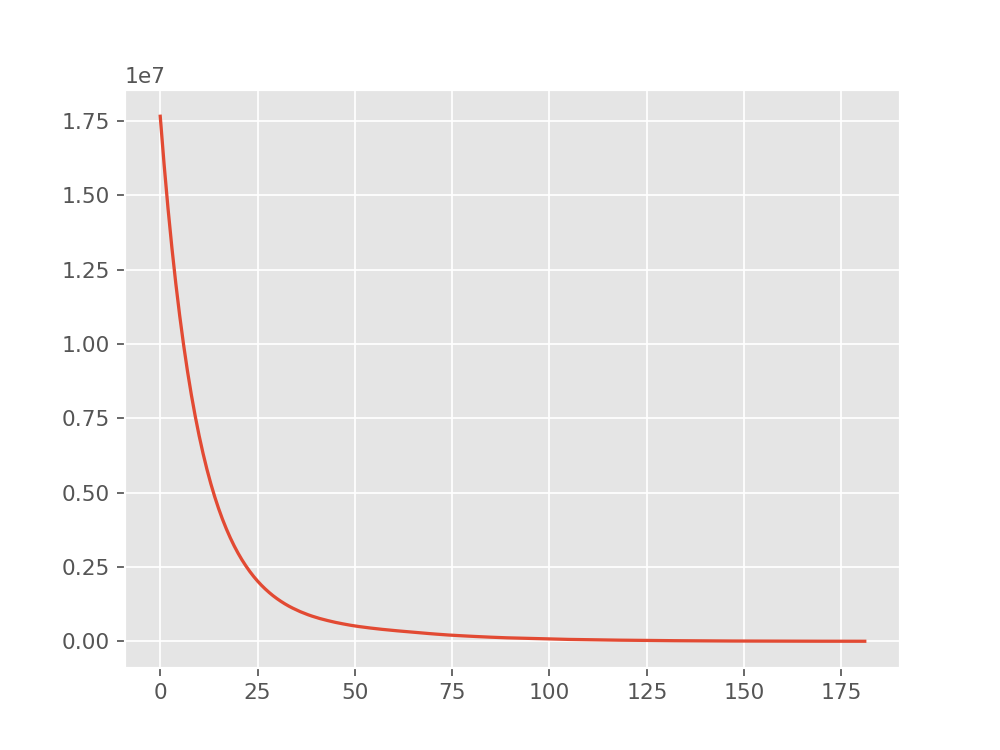

In [99]:
# get all cross validation errors
errors_val = [mean_squared_error(y_s, y_val_pred) for y_s in gb_regtree.staged_predict(X_val)]
# error vs number of trees (iteration)
_, axgbrt = plt.subplots()
axgbrt.plot(range(gb_regtree.n_estimators),errors_val)
# print('MSE (mean cross-validation) = {:.4f}'.format(min_val_error) )
# print('RMSE (mean cross-validation) = {:.4f}'.format(np.sqrt(min_val_error)) )

# Stacking Ridge and GBRT

In [105]:
# split training set in two
from sklearn.model_selection import train_test_split
X_1, X_2, y_1, y_2 = train_test_split(X, y, test_size=0.5, random_state=4)

# re-train Ridge and GBRT on 1st half
from sklearn.base import clone
# make a copy of all hyperparameters (no fitted data)
gbrt_stack = clone(gb_regtree)
ridge_stack = clone(model_ridge)
# train
# from joblib import Parallel, delayed
# def fit_more(model, X, y):
#     model.fit(X, y)
# Parallel(n_jobs=-1)(delayed(fit_more)(m, X_1, y_1)
#                            for m in [gbrt_stack, ridge_stack])
gbrt_stack.fit(X_1, y_1)
ridge_stack.fit(X_1, y_1)

      Iter       Train Loss      OOB Improve   Remaining Time 
         1    23414163.6369     1773161.2426           30.57m
         2    21796900.8094     1605078.1574           31.94m
         3    20288903.5257     1452611.7795           31.54m
         4    18966370.3207     1314920.3616           32.34m
         5    17795606.3519     1180170.8543           33.35m
         6    16708067.7833     1059706.9326           33.04m
         7    15684072.4841      969642.1813           33.09m
         8    14832949.0964      871485.4344           33.80m
         9    14000583.4748      794389.7289           33.70m
        10    13314551.1124      705001.5615           33.59m
        20     8944492.6307      249696.5956           33.65m
        30     7198928.6671       86431.5149           33.83m
        40     6428848.0867       31277.9784           34.37m
        50     6032890.6899        6140.8446           33.88m
        60     5808229.4572       -1821.4507           33.34m
       

In [185]:
# Ridge and GBRT predictions on 2nd half
gbrt_pred = gbrt_stack.predict(X_2)
ridge_pred = ridge_stack.predict(X_2)
X_blender = np.stack((gbrt_pred, ridge_pred), axis=1)

In [186]:
# alpha array for grid search
alpha_arr = np.array([ 10**x for x in range(-2,1)])
alpha_arr = np.concatenate([alpha_arr, 3*alpha_arr])
print('{}'.format(alpha_arr))

[ 0.01  0.1   1.    0.03  0.3   3.  ]


In [187]:
# train blender
from sklearn.linear_model import Ridge
model_blr = Ridge(alpha=0.1, random_state=29, solver='svd')

# polynomial features
from sklearn.preprocessing import PolynomialFeatures
polystack = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_blender_poly = polystack.fit_transform(X_blender)
# NOTE: no need to do feature scaling since ridge is a closed-form
# X_blender_poly = X_blender
# X_blender_poly = np.concatenate( [X_blender**x for x in range(1,2)] , axis = 1)

# Grid search on max_depth, min_samples_leaf
from sklearn.model_selection import GridSearchCV, ShuffleSplit
# n_splits is the number of times you split data after shuffling
cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# cv could be a fixed number of partitions but there would be no shuffling in that case
# it will just rotate on partitions (k-1) parts and 1 part for cross-val
param_grid_model_blr = [ {'alpha': alpha_arr} ]
model_blr_grid = GridSearchCV(model_blr, param_grid_model_blr, cv=cv,\
                          scoring='neg_mean_squared_error', n_jobs=-1)
# run grid search
model_blr_grid.fit( X_blender_poly , y_2 )

# best of mean test score
print( 'MSE, best param, mean cross-val = {:.4f}'.format(-model_blr_grid.best_score_) )
print( 'RMSE, best param, mean cross-val = {:.4f}'.format(np.sqrt(-model_blr_grid.best_score_)) )
print(model_blr_grid.best_estimator_)

# from sklearn.model_selection import cross_validate, ShuffleSplit
# # n_splits is the number of times you split data after shuffling
# cv = ShuffleSplit(n_splits=5, test_size=1/5, random_state=4)
# # cv could be a fixed number of partitions but there would be no shuffling in that case
# # it will just rotate on partitions (k-1) parts and 1 part for cross-val
# cv_results_stack = cross_validate(model_blr, X_blender_poly, y=y_2, cv=cv,\
#                     scoring = 'neg_mean_squared_error', n_jobs = -1, verbose = 1)
# print('MSE (mean cross-validation) = {:.4f}'.format(\
#                                     -np.mean(cv_results_stack['test_score'])))
# print('RMSE (mean cross-validation) = {:.4f}'.format(\
#                                     np.sqrt(-np.mean(cv_results_stack['test_score']))))

# RMSE (mean cross-validation) = 2491.9860 , best score
# degree = 2 and interaction only, 2492.7513

# model_blr.fit(X_blender, y_2)
# # RSME on trained data, just to get an idea
# blr_pred = model_blr.predict(X_blender)
# np.sqrt(mean_squared_error(y_2, blr_pred))

MSE, best param, mean cross-val = 6209994.2019
RMSE, best param, mean cross-val = 2491.9860
Ridge(alpha=3.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=29, solver='svd', tol=0.001)


<IPython.core.display.Javascript object>


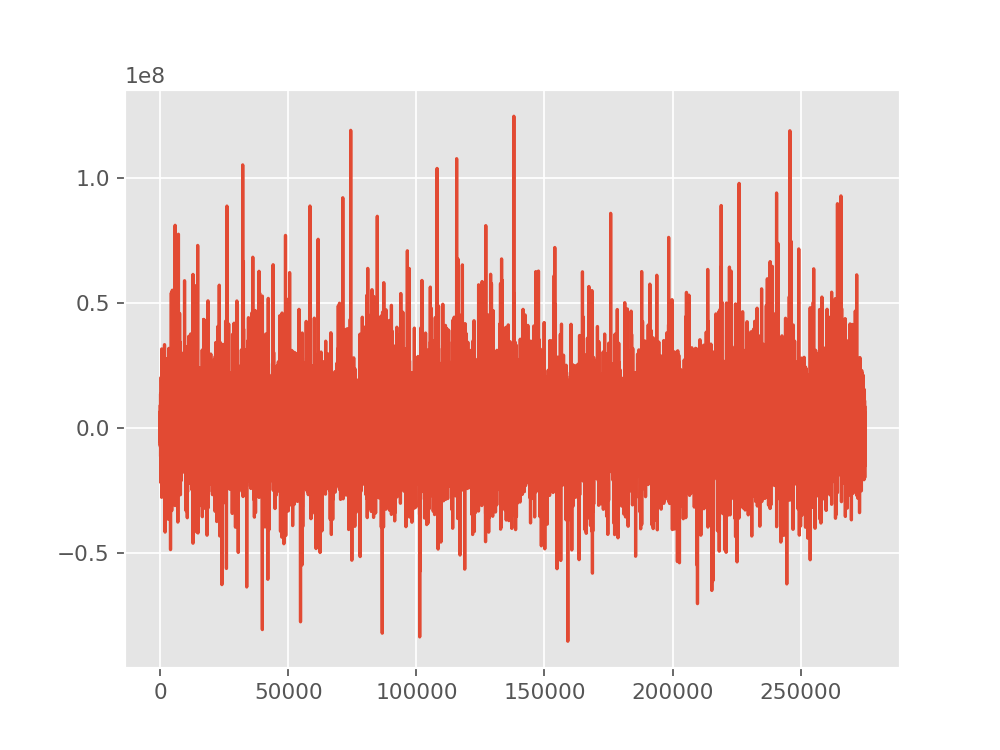

3996639.84649


In [110]:
# plot errors for gbrt and ridge
_, axsterr = plt.subplots()
stack_error = (gbrt_pred-y_2)**2 - (ridge_pred-y_2)**2
axsterr.plot(stack_error)
print(np.std(stack_error))

In [104]:
# try decision tree blender instead of Ridge

None


#### Modules version

In [ ]:
import sys
# sys.version_info for version formatted
print('Python version = {}'.format(sys.version.split('|', maxsplit=1)[0].strip()))
print('Pandas version = {}'.format(pd.__version__))
print('NumPy version = {}'.format(np.__version__))
print('Matplotlib version = {}'.format(sys.modules[plt.__package__].__version__))
skl = LabelEncoder.__module__.split('.', maxsplit=1)[0]
print('scikit-learn version = {}'.format(sys.modules[skl].__version__))
sci = csr_matrix.__module__.split('.', maxsplit=1)[0]
print('SciPy version = {}'.format(sys.modules[sci].__version__))
print('Seaborn version = {}'.format(sn.__version__))

## TODO
- check instances with highest error and lowest error (done, see above)
        Highest error analysis on Linear Regression is done
- check correlation after feature extraction (done, could combine Prod_cat123 with Gender and reevaluate but Gender does not improve our model...)
- correct for imbalance of instances based on Product ID (done, Rare Product Category123 and Rare Product ID do not yield worst predictions), about 2/3 of rare users (<16 instances) yields very high error.
        Add sample weights according to Users ID (?)
        Tried to remove instances of high error and retrain data => train accuracy up but test accuracy down!
- try decision  (done, need to optimize hyperparameters)
- try adding age as contineous feature (given as categorical)